# Helium Triplet Parker Wind Modelling ($\texttt{p-winds}$) | Nested Sampling ($\texttt{dynesty}$) | Gaussian Process Tutorial ($\texttt{celerite}$) Tutorial

## Helium Triplet Transmission Spectrum to Mass-Loss Parameters

This notebook contains most of what you need to turn your helium triplet transit spectrum into physical mass-loss parameters using gaussian process and nested sampling, enabling you to characterize atmospheric escape in your exoplanet. 

The $\texttt{data/}$ directory contains the necessary data to execute this analysis. This data was published in [R. Allart et al. (2018)](https://www.science.org/doi/10.1126/science.aat5879).

We guide you through a modeling framework built around Gaussian Processes for correlated noise modeling and nested sampling for robust parameter estimation. While we motivate the use of these methods, we intentionally treat them as black-box tools in this tutorial, focusing instead on practical implementation.

### Relevant Packages

For more information on the tools used in this analysis, see the official repositories (and the references therein) of the key packages:

- [`celerite`](https://github.com/dfm/celerite) — Gaussian Processes  
- [`dynesty`](https://github.com/joshspeagle/dynesty) — Nested Sampling  

---

This notebook accompanies the publication:

**McCreery et al. (2025)** —  
[“Tracing the Winds: A Uniform Interpretation of Helium Escape in Exoplanets from Archival Spectroscopic Observations”](https://ui.adsabs.harvard.edu/abs/2025ApJ...980..125M/abstract), *ApJ, 980, 125*

### A horrible amount of imports

In [1]:
import urllib
import numpy as np
import astropy.units as u
import astropy.constants as c
from p_winds import tools, parker, hydrogen, helium, transit, lines
from astropy.convolution import convolve
from scipy.special import voigt_profile
import dynesty
import celerite
from celerite import terms
from scipy.stats import norm
import pickle as pkl
import requests
import urllib.parse
from matplotlib.colors import to_rgba
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from corner import corner
import ray
from ray.util.multiprocessing import Pool
import os

### Useful functions

In [2]:
# Gather planet data in a way you like, here's a quick function to do it for you using ExoMAST.
def getPlanetData(target_name):
    base_url = "https://exo.mast.stsci.edu/api/v0.1/exoplanets"
    try:
        canonical = requests.get(f"{base_url}/identifiers/", params={"name": target_name}).json()['canonicalName']
        encoded = urllib.parse.quote(canonical, encoding='utf-8')
        data = requests.get(f"{base_url}/{encoded}/properties/").json()
        if not data:
            raise ValueError("No data found for this target")
        for source in ['nexsci', 'exoplanets.org']:
            for entry in data:
                if entry.get('catalog_name') == source:
                    return entry
        return data[0]
    except KeyError:
        raise ValueError("Canonical name not found for target")

def gaussian(x, mu=0.0, sigma=1.0):
    return 1 / sigma / (2 * np.pi) ** 0.5 * np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)

# Define the instrumental profile. Includes useful instruments often used for helium escape analysis.
def instrument(wl_obs, name):
    wl_mean = np.mean(wl_obs)
    print(f"Using {name} instrumental profile")

    if name == 'NIRSPEC':
        width = 3.5 * (max(wl_obs) - min(wl_obs)) / (2 * len(wl_obs))
        x = np.linspace(min(wl_obs - wl_mean), max(wl_obs - wl_mean), len(wl_obs))
        return voigt_profile(x, 0.0, width)

    elif name == 'CARMENES':
        fwhm_kms = 3.7
        sigma = fwhm_kms / (2 * np.sqrt(2 * np.log(2))) / c.c.to(u.km/u.s).value * wl_mean
        return gaussian(wl_obs, wl_mean, sigma)

    elif name == 'WINERED':
        sigma = 0.16 / (2 * np.sqrt(2 * np.log(2)))
        return gaussian(wl_obs, wl_mean, sigma)

    elif name == 'SOSS':
        print('JWST/SOSS resolving power approx. 650. Use with caution.')
        sigma = wl_mean / 650
        return gaussian(wl_obs, wl_mean, sigma)

    else:
        print('Instrument not supported.')
        return None

# Read in the transmission spectrum
def transmissionSpectrum(file, instrument_name):
    wl_obs, f_obs, u_obs = np.loadtxt(file, skiprows=1).T

    if instrument_name in ['NIRSPEC', 'CARMENES', 'SOSS']:
        s = 1E4 / np.mean(wl_obs)
        n = 1 + 8.34254e-5 + 0.02406147 / (130 - s**2) + 0.00015998 / (38.9 - s**2)
        wl_obs /= n

    elif instrument_name == 'WINERED':
        print('Not converting in-vacuum wavelengths to in-air.')

    return wl_obs, f_obs, u_obs

# Read in the host spectrum, including proxies. Note: Read the p-winds documentation about using proxies and installation processes.
def hostspec(param):
    use_host, filename = param
    if use_host:
        spec = np.loadtxt(filename)
        return {
            'wavelength': spec[:, 0],
            'flux_lambda': spec[:, 1],
            'wavelength_unit': u.angstrom,
            'flux_unit': u.erg / u.s / u.cm**2 / u.angstrom
        }
    else:
        print('Proxy spectrum setup not implemented. Refer to p-winds documentation.')
        return None
        # host_spectrum = tools.generate_muscles_spectrum(file, reference_spectra_dir='/data/MUSCLES/', semi_major_axis=a_rs)
        # return host_spectrum

### Now we define system parameters and the data being utilized.

The includes hydrogen fraction, which is an extremely important parameter and the subject of much study. We set it =.90 here to be consistent with the original $\texttt{p-winds}$ tutorial.

There is a line below that should be uncommented if you get an error about odd-axes. I remove the final elements of the observation to fix this.

In [3]:
target_name = 'HAT-P-11b'  # Your target!
instrument_name = 'CARMENES'  # Observation instrument!
hs = [True, 'data/hatp11b_sed.dat']  # Location of your high energy spectrum! [(True = have a sed, False = using a proxy), (if True = location of sed, if False = name of proxy being used)]
transmission_spec_file = 'data/hatp11b.dat'  # Location of your helium transmission spectrum!

planet_data = getPlanetData(target_name)
R_star = planet_data['Rs']  # Stellar radius (solar radii)
M_star = planet_data['Ms'] # Stellar mass (solar masses)
R_pl = planet_data['Rp']  # Planetary radius (Jupiter radii)
M_pl = planet_data['Mp']  # Planetary mass (Jupiter masses)
a_pl = planet_data['orbital_distance']  # Semi-major axis (au)
a_rs = planet_data['a/Rs']  # Semi-major axis in units of stellar radii
planet_to_star_ratio = planet_data['Rp/Rs'] # Planet-to-star ratio
impact_parameter = planet_data['impact_parameter'] # Impact Parameter

# Save the information to a pickle file for future reference.
dict_path = target_name + '_dict.pickle'
with open(dict_path, 'wb') as pickle_file:
    pkl.dump(planet_data, pickle_file)

# --- Abundances and Composition ---
h_fraction = 0.90
he_fraction = 1 - h_fraction
he_h_ratio = he_fraction / h_fraction
mean_f_ion = 0.90  # Assumed; updated during model relaxation
mu_0 = (1 + 4 * he_h_ratio) / (1 + he_h_ratio + mean_f_ion)  # Mean molecular weight

# --- Physical Constants (cgs / SI mixed units) ---
m_h = c.m_p.to(u.g).value  # Hydrogen mass [g]
m_He = 4 * 1.67262192369e-27  # Helium mass [kg]
k_B = 1.380649e-23  # Boltzmann constant [J/K]

# --- Model Sampling Parameters ---
r = np.logspace(0, np.log10(20), 100)  # Altitude samples [unitless scale height?]
initial_f_ion = 0.0                    # Initial H ionization fraction
initial_f_he = np.array([1.0, 0.0])    # He singlet/triplet initial state

# --- Model Configuration Flags ---
relax_solution = True
exact_phi = True
sample_phases = np.linspace(-0.5, 0.5, 5)  # Orbital phases (1st to 4th contact)
n_samples = len(sample_phases)

transit_grid_size = 100       # Radial bins for transit simulation
supersampling = 5             # For antialiasing pixel edges in ray tracing

# --- He Triplet Line Properties ---
w0, w1, w2, f0, f1, f2, a_ij = lines.he_3_properties()
w_array = np.array([w0, w1, w2])
f_array = np.array([f0, f1, f2])
a_array = np.full(3, a_ij)

# --- Load Observations ---
wl_obs, f_obs, u_obs = transmissionSpectrum(transmission_spec_file, instrument_name)
# Trim last element (optional if odd-axis value exists)
# wl_obs, f_obs, u_obs = wl_obs[:-1], f_obs[:-1], u_obs[:-1]

x, y, yerr = wl_obs, f_obs, u_obs

# --- Instrument and Host Spectrum ---
instrumental_profile = instrument(wl_obs, instrument_name)
host_spectrum = hostspec(hs)

# --- Trim out-of-feature data ---
inds_out = np.where(np.logical_or(x < 10828, x > 10832))[0] # Rough outline of the out-of-feature data
x_out, y_out, yerr_out = x[inds_out], y[inds_out], yerr[inds_out] # Make the cuts

Using CARMENES instrumental profile


### Define functions to model the helium triplet

In [4]:
# Now for the meat of it. These are the functions you spend time with
def atmospheric_model(theta):
    log_m_dot, log_T = theta
    m_dot, T = 10 ** log_m_dot, 10 ** log_T

    # Hydrogen ionization and mean molecular weight (μ)
    f_r, mu_bar = hydrogen.ion_fraction(
        r, R_pl, T, h_fraction, m_dot, M_pl, mu_0,
        star_mass=M_star, semimajor_axis=a_pl,
        spectrum_at_planet=host_spectrum, exact_phi=True,
        initial_f_ion=initial_f_ion, relax_solution=True,
        return_mu=True
    )

    # Outflow structure with tidal effects
    vs = parker.sound_speed(T, mu_bar)
    rs = parker.radius_sonic_point_tidal(M_pl, vs, M_star, a_pl)
    rhos = parker.density_sonic_point(m_dot, rs, vs)
    r_scaled = r * R_pl / rs
    v_arr, rho_arr = parker.structure_tidal(r_scaled, vs, rs, M_pl, M_star, a_pl)

    # Helium population fractions
    f_he_1, f_he_3 = helium.population_fraction(
        r, v_arr, rho_arr, f_r, R_pl, T, h_fraction,
        vs, rs, rhos, spectrum_at_planet=host_spectrum,
        initial_state=initial_f_he, relax_solution=relax_solution,
        method="Radau"
    )

    # Helium number density and its populations
    n_he_total = rho_arr * rhos * he_fraction / (1 * h_fraction + 4 * he_fraction) / m_h
    n_he_1 = f_he_1 * n_he_total
    n_he_3 = f_he_3 * n_he_total
    n_he_ion = (1 - f_he_1 - f_he_3) * n_he_total

    return n_he_1, n_he_3, n_he_ion, v_arr * vs


def transmission_model(wavelength_array, v_wind, n_he_3_dist, log_T, v_array):
    T = 10 ** log_T

    R_pl_m = R_pl * 71492000  # Planet radius [m]
    r_SI = r * R_pl_m  # Altitudes [m]
    v_SI = v_array * 1000  # Outflow velocity [m/s]
    n_he_3_SI = n_he_3_dist * 1e6  # Density [1/m^3]

    # Transit geometry setup
    transit_results = [transit.draw_transit(
        planet_to_star_ratio,
        impact_parameter=impact_parameter,
        supersampling=supersampling,
        phase=phase,
        planet_physical_radius=R_pl_m,
        grid_size=transit_grid_size
    ) for phase in sample_phases]

    # Perform radiative transfer + add continuum-less transit depth
    spectra = [
        transit.radiative_transfer_2d(f_map, r_map, r_SI, n_he_3_SI, v_SI,
                                      w_array, f_array, a_array, wavelength_array,
                                      T, m_He, bulk_los_velocity=v_wind,
                                      wind_broadening_method='average') + depth
        for (f_map, depth, r_map) in transit_results
    ]

    return np.mean(spectra, axis=0)


def cascading_model(theta, wavelength_array):
    log_m_dot, log_T, v_wind = theta
    n_he_1, n_he_3, n_he_ion, v = atmospheric_model((log_m_dot, log_T))
    t_spec = transmission_model(wavelength_array, v_wind, n_he_3, log_T, v)
    return convolve(t_spec, instrumental_profile, boundary='extend')

### Perform the out-of-feature correlated noise fitting

In [5]:
def gp_prior_transform(params):
    gp1i, gp2i = params
    gp1 = 10 * gp1i - 10 # Change as you see fit, but I rarely do.
    gp2 = 20 * gp2i - 10 # Change as you see fit, but I rarely do.
    return gp1, gp2

def gp_loglike(params):
    gp1, gp2 = params
    try:
        model = 1 # Continuum should be at 1.
        resid = y_out - model
        gp.set_parameter_vector([gp1, gp2])
        return gp.log_likelihood(resid)
    except RuntimeError or RuntimeWarning:
        return -1e100

# Check if results already exist, do the nested sampling if not.
if os.path.exists("GP_results.pickle"):
    print("GP_results.pickle found. Loading cached results...")
    with open("GP_results.pickle", "rb") as file:
        results = pkl.load(file)
else:
    print("No cached result found. Running NestedSampler...")

    # Set up GP
    kernel = terms.Matern32Term(
        log_sigma=np.log10(np.var(y_out)),
        log_rho=np.log10(np.mean(np.diff(x_out)))
    )
    gp = celerite.GP(kernel, mean=0.0)
    gp.compute(x_out, yerr_out)

    # Set up and run dynesty sampler
    sampler = dynesty.NestedSampler(
        gp_loglike,
        gp_prior_transform,
        ndim=2,
        bound='multi'
    )
    sampler.run_nested()
    results = sampler.results

    # Save results
    with open("GP_results.pickle", "wb") as file:
        pkl.dump(results, file)

# Extract samples and compute posteriors
samples = np.array(results.samples)
mu1, mu2 = np.median(samples[:, 0]), np.median(samples[:, 1])
var1, var2 = np.var(samples[:, 0]), np.var(samples[:, 1])

GP_results.pickle found. Loading cached results...


### Perform the full fit using the out-of-feature posteriors

This includes ray integration, which parallelizes the process and speeds it up. This is very helpful to use on remote servers, but also provides good performance on local machines. I have adjusted the priors and the nested sampler parameters to speed things up a bit. More live points and wider priors is a good idea for a run where you don't already know the posteriors beforehand.

Nested samplers take in unit uniform priors, so perform transformations to the priors as you see necessary.

Running a large dataset on sufficiently wide priors may take up to a day. This specific dataset is small and I have restricted the prior space, so the runtime shouldn't be terrible. If you get solve_ivp errors, adjust your priors, as p-winds is likely unable to run in certain parameter spaces. This is often a problem with the temperature. Increase the lower bound of the prior by intervals of ~.05 -- including the error in the likelihood rejection is another option. 

In [6]:
# Re-initialize a model for the full fit using the proper x, y, and yerr
kernel = terms.Matern32Term(log_sigma=np.log10(np.var(y)), log_rho=np.log10(np.mean(np.diff(x))))
gp = celerite.GP(kernel, mean=0.0)
gp.compute(x, yerr)

def loglike(params):
    gp1, gp2, log_m, log_T, v = params
    try:
        resid = y - cascading_model((log_m, log_T, v), x / 1e10)
        gp.set_parameter_vector([gp1, gp2])
        return gp.log_likelihood(resid)
    except (RuntimeError, RuntimeWarning):
        return -1e100

def prior_transform(params):
    gp1i, gp2i, mi, ti, vi = params
    gp1 = norm.ppf(gp1i, loc=mu1, scale=var1)
    gp2 = norm.ppf(gp2i, loc=mu2, scale=var2)
    log_m = 1 * mi + 10 # This requires a bit of context and prior knowledge of the physical space your priors take up.
    log_T = .5 * ti + 3.65 # Same as above.
    v = 30000 * vi - 15000 # This is a wide prior and I don't change this really as this parameter isn't super important and the specific value of v doesn't impact likelihood evaluation times.
    return gp1, gp2, log_m, log_T, v

# THIS PARALLELIZES THE WHOLE THING. This is very time intensive. I've uploaded posterior results so we don't have to wait a whole day for this to run.
if os.path.exists("NS_results.pickle"):
    print("NS_results.pickle found. Loading cached results...")
    with open("NS_results.pickle", "rb") as file:
        NS_res = pkl.load(file)
else:
    print("No cached result found. Running NestedSampler...")

    n_cpu = 10
    queue_size = n_cpu
    ndim = 5

    ray.init(num_cpus=n_cpu)
    with Pool(processes=n_cpu) as pool:
        sampler = dynesty.NestedSampler(
            loglike,
            prior_transform,
            ndim=ndim,
            bound='multi', # Changeable
            pool=pool,
            queue_size=queue_size,
            nlive=200, # Changeable
            sample='rwalk' # Changeable
        )
        sampler.run_nested()
    ray.shutdown()

    NS_res = sampler.results
    with open("NS_results.pickle", "wb") as file:
        pkl.dump(NS_res, file)

NS_results.pickle found. Loading cached results...


# Plotting

Some generic plotting that might inspire other possible insightful plots.

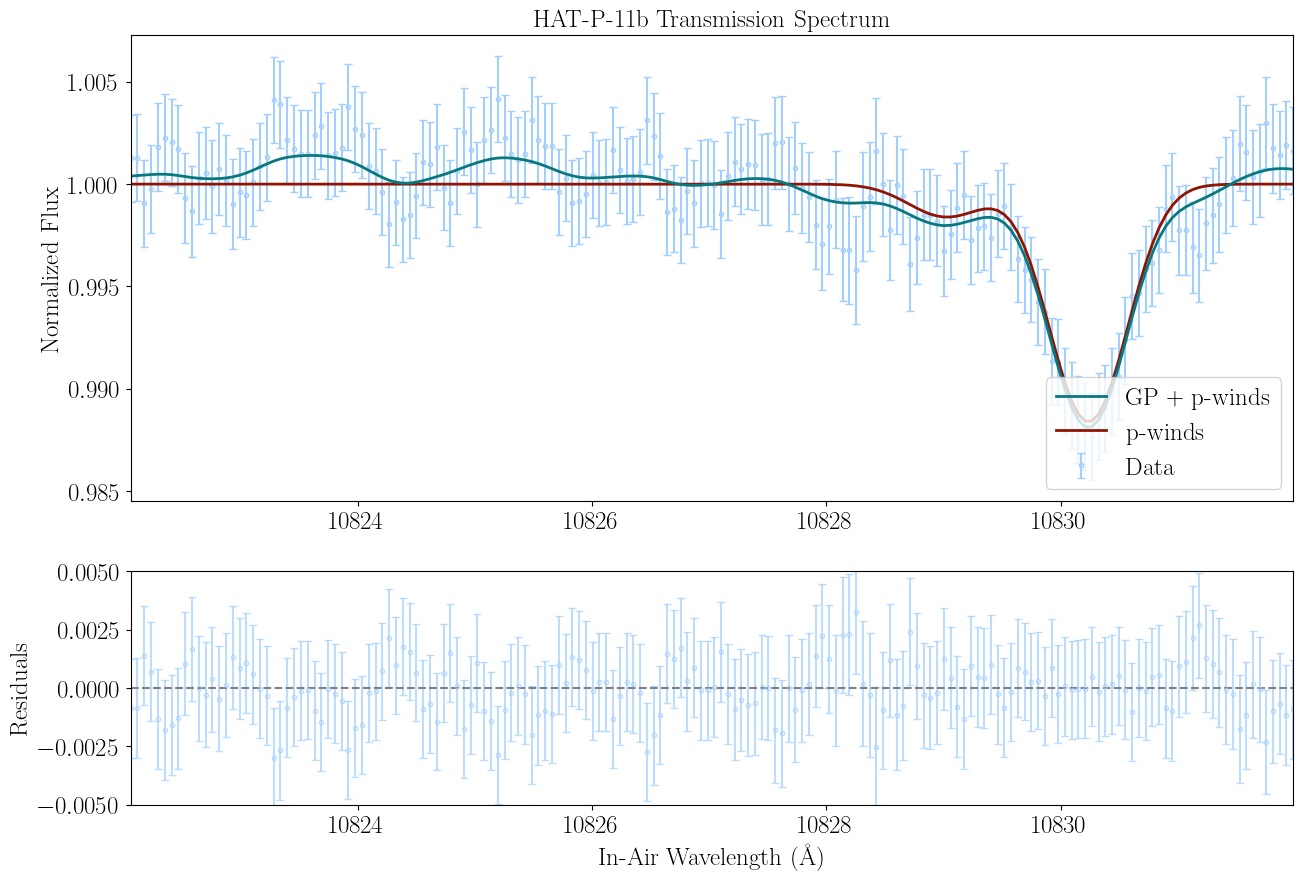

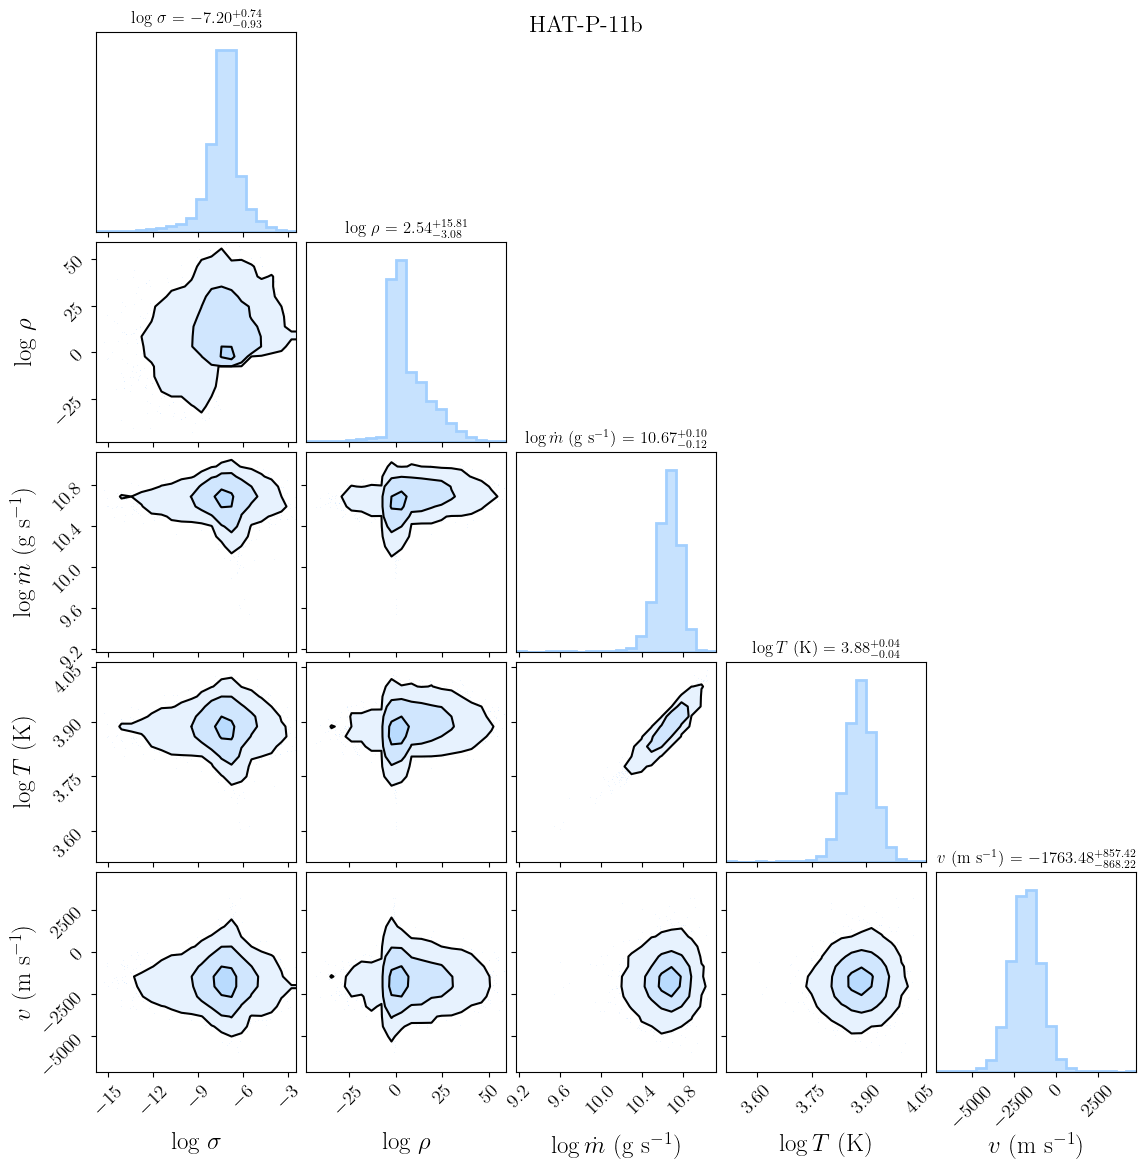

In [7]:
# Matplotlib settings you probably want
plt.rcParams['font.family'] = "serif"
plt.rcParams['text.usetex'] = True
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 14
c1 = 'xkcd:deep aqua'
c2 = 'xkcd:brick red'
c3 = 'xkcd:baby blue'

with open('NS_results.pickle', 'rb') as file:
    nested_results = pkl.load(file)

weights_lt = np.exp(nested_results['logwt'] - nested_results['logz'][-1])
new_lt_samples = dynesty.utils.resample_equal(nested_results['samples'], weights_lt)

# TRANSMISSION SPECTRUM AND RESIDUALS
point = nested_results['samples'][-1]

# Evaluate deterministic model
y_model = cascading_model((point[2], point[3], point[4]), x / 1e10)

# GP models the residuals only
resid = y - y_model
kernel = celerite.terms.Matern32Term(log_sigma=point[0], log_rho=point[1])
gp = celerite.GP(kernel, mean=0.0)
gp.compute(x, yerr)

# Predict the residual component
mu_resid, var_resid = gp.predict(resid, x, return_var=True)

# Total model = deterministic model + GP residual component
mu = y_model + mu_resid

fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 1, height_ratios=[2, 1])

ax1 = plt.subplot(gs[0])
ax1.plot(x, mu, linewidth=2, label='GP + p-winds', c=c1, zorder=2)
ax1.plot(x, y_model, linewidth=2, label='p-winds', c=c2, zorder=1)
ax1.errorbar(x, y, yerr, fmt='o', label='Data', c=c3, markerfacecolor='none', markersize=3, capsize=3, zorder=0)
ax1.set_title(target_name + r' Transmission Spectrum', fontsize=18)
ax1.legend(loc='lower right', fontsize=18)
ax1.set_ylabel('Normalized Flux', fontsize=18)
ax1.set_xlim(np.min(x), np.max(x))
ax1.tick_params(axis='both', which='major', labelsize=18)

ax2 = plt.subplot(gs[1])
ax2.errorbar(x, mu - y, yerr, fmt='o', c=c3, markerfacecolor='none', markersize=3, capsize=3, zorder=0, alpha=.7)
ax2.set_ylabel('Residuals', fontsize=18)
ax2.set_xlabel('In-Air Wavelength (\AA)', fontsize=18)
ax2.axhline(0, color='gray', linestyle='dashed', zorder=0)
ax2.set_ylim(-.005, .005)
ax2.set_xlim(np.min(x), np.max(x))
ax2.tick_params(axis='both', which='major', labelsize=18)
plt.savefig('spectrum.png')

# Corner plot remains unchanged
hist_kwargs2 = {'histtype': 'stepfilled', 'facecolor': to_rgba(c3, .6),
                'edgecolor': to_rgba(c3, 1), 'linewidth': 2}
contourf_kwargs2 = {'colors': [to_rgba(c3, a) for a in np.linspace(0, 1, 5)]}
data_kwargs2 = {'color': c3, 'ms': 0.5, 'alpha': .5}
labels = ['log $\sigma$', 'log $\\rho$', '$\log \dot{m}$ (g s$^{-1}$)', '$\log T$ (K)', '$v$ (m s$^{-1}$)']
c = corner(new_lt_samples, labels=labels, smooth=None, fill_contours=True, plot_density=False,
           hist_kwargs=hist_kwargs2, data_kwargs=data_kwargs2, contourf_kwargs=contourf_kwargs2,
           show_titles=True, titles=labels, levels=1.0 - np.exp(-0.5 * np.arange(1.0, 3.1, 1.0) ** 2),
           title_kwargs={"fontsize": 12}, label_kwargs={'fontsize': 18})
plt.suptitle(target_name)
plt.savefig('corner.png')